# Predicción de default financiero usando métodos de aprendizaje automático
### Implementación del modelo y entrenamiento

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

In [17]:
# Tratamiento de datos
# ==============================================================================
# TODO: Organizar imports, algunos no se usan, otros están repetidos.
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math


#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor

#Creación de modelos
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import ComplementNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# oversampling with smote with 10% of majority class
from imblearn.over_sampling import SMOTE
from collections import Counter
# undersample majority class with RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

# Cross validation using RepeatStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


In [18]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=40,ax=ax, facecolor='midnightblue', edgecolor='black')
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        # remove grid lines
        ax.grid(False)

        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks

    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


# Dataset

In [19]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('data/Preprocessed.csv')
d.head(10)

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes,OcurrenciasMora
0,1,0.766127,0.272727,0.153846,0.000201,0.45600,0.228070,0.000000,0.30,0.0,0.50,0.105263
1,0,0.957151,0.215909,0.000000,0.000030,0.13000,0.070175,0.000000,0.00,0.0,0.25,0.000000
2,0,0.658180,0.193182,0.076923,0.000021,0.15210,0.035088,0.058824,0.00,0.0,0.00,0.105263
3,0,0.233810,0.102273,0.000000,0.000009,0.16500,0.087719,0.000000,0.00,0.0,0.00,0.000000
4,0,0.213179,0.602273,0.000000,0.000094,0.17500,0.052632,0.000000,0.05,0.0,0.25,0.000000
5,0,0.754464,0.204545,0.000000,0.000052,0.17500,0.140351,0.000000,0.00,0.0,0.00,0.000000
6,0,0.116951,0.068182,0.000000,0.011500,0.27080,0.035088,0.000000,0.00,0.0,0.00,0.000000
7,0,0.644226,0.102273,0.000000,0.000077,0.12500,0.087719,0.000000,0.00,0.0,0.00,0.000000
8,0,0.018798,0.340909,0.000000,0.000133,0.32505,0.122807,0.000000,0.10,0.0,0.50,0.000000
9,0,0.010352,0.284091,0.000000,0.000075,0.62270,0.228070,0.000000,0.10,0.0,0.50,0.000000


In [20]:
d.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes,OcurrenciasMora
count,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000,140742.000000
mean,0.058867,0.301405,0.358040,0.017372,0.060150,0.297039,0.147343,0.004643,0.049041,0.005151,0.174893,0.019023
std,0.235376,0.337377,0.169160,0.050873,0.172924,0.167179,0.089137,0.026077,0.052463,0.027586,0.258636,0.053508
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.027972,0.227273,0.000000,0.000044,0.192500,0.087719,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.141092,0.352273,0.000000,0.000091,0.270800,0.140351,0.000000,0.050000,0.000000,0.000000,0.000000
75%,0.000000,0.514463,0.477273,0.000000,0.000202,0.364537,0.192982,0.000000,0.100000,0.000000,0.250000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#dividiendo el df en entradas y salidas
X = d.drop(columns=['Incumplimiento'])
y = d['Incumplimiento']

In [22]:
# Se hace la separación del dataset para entrenamiento y evaluación.
# 30% sería para evaluación y 70% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.reshape(-1,1),
    train_size = 0.7,
    random_state=282,
    shuffle=True
)
y_train = y_train.ravel()
y_test = y_test.ravel()
print('Tamaño del dataset de entrenamiento: ', X_train.shape)
print('Tamaño del dataset de evaluación: ', X_test.shape)
print('Tamaño del dataset de entrenamiento: ', y_train.shape)
print('Tamaño del dataset de evaluación: ', y_test.shape)

Tamaño del dataset de entrenamiento:  (98519, 11)
Tamaño del dataset de evaluación:  (42223, 11)
Tamaño del dataset de entrenamiento:  (98519,)
Tamaño del dataset de evaluación:  (42223,)


# Desbalance de clases

In [23]:
# analyze class imbalance
print('Porcentaje de Incumplimiento en el dataset original: ', round(d['Incumplimiento'].value_counts()[1]/len(d) * 100,2), '%')
print('Porcentaje de Incumplimiento en el dataset de entrenamiento: ', round(pd.DataFrame(y_train)[0].value_counts()[1]/len(y_train) * 100,2), '%')
print('Porcentaje de Incumplimiento en el dataset de evaluación: ', round(pd.DataFrame(y_test)[0].value_counts()[1]/len(y_test) * 100,2), '%')

Porcentaje de Incumplimiento en el dataset original:  5.89 %
Porcentaje de Incumplimiento en el dataset de entrenamiento:  5.84 %
Porcentaje de Incumplimiento en el dataset de evaluación:  6.0 %


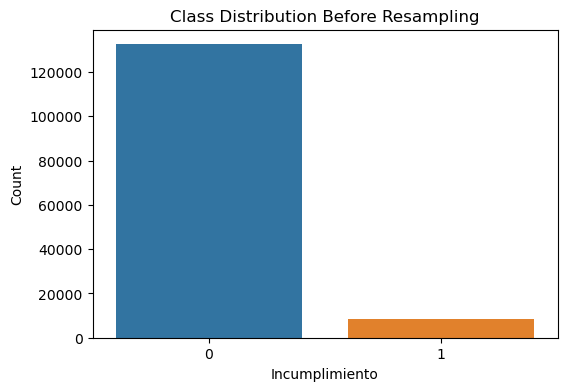

In [24]:
# plot the imbalance
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Incumplimiento', data=d, ax=ax)
ax.set_title('Class Distribution Before Resampling')
ax.set_xlabel('Incumplimiento')
ax.set_ylabel('Count')
plt.show()

Se cuenta con un desbalance importante teniendo una clase minoritaria de 6% y una clase mayoritaria del 94% sobre el total de los datos. Para esto es necesario aplicar tecnicas de balanceo de clases para que los resultados de los modelos seán optimos. 

## SMOTE y RandomUnderSampler
Aplicamos inicialmente un sobremuestreo en la clase minoritaria equivalente al 10% del total de observaciones de la clase mayoritaria. Luego, basado en las recomendaciones del paper original que propone SMOTE, aplicamos un submuestreo en la clase mayoritaria equivalente al 50% del total de observaciones de la clase minoritaria. De esta manera la relación entre clases queda en 2:1. Esta operación solo se realiza en el conjunto de entrenamiento.

In [25]:
oversample = SMOTE(sampling_strategy=0.1)
X_train, y_train = oversample.fit_resample(X_train, pd.DataFrame(y_train)[0])

# analyze class imbalance
print(Counter(y_train))

Counter({0: 92769, 1: 9276})


In [26]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, pd.DataFrame(y_train)[0])
# summarize class distribution
print(Counter(y_train))


Counter({0: 18552, 1: 9276})


Accuracy: 89.89%
Precision: 30.90%
Recall: 55.38%
F1: 39.67%
AUC: 0.857


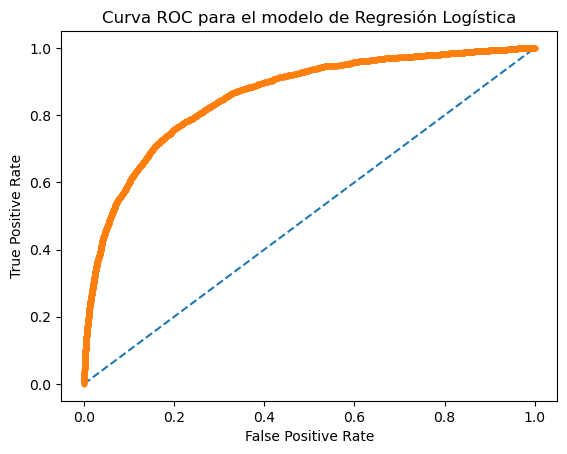

In [40]:
# model to test the class balance effect
modelXGB = XGBClassifier( n_estimators = 150, learning_rate=0.05, max_depth = 5) \
                .fit(X_train, y_train)


# make predictions for test data
y_pred = modelXGB.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))


# predict probabilities
probs = modelXGB.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Curva ROC para el modelo de Regresión Logística')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Haciendo una prueba con el modelo de XGBoost se encuentra que con el balanceo de clases se obtiene un mejor recall del ~56% y f1 de ~39% en el conjunto de validación, a la vez que se mantiene un accuracy de ~89% y AUC de 85.7%. Esto puede indicar que aunque se disminuyo la cantidad de observaciones, no se afectaron los resultados de la clasificación, contrario a ello, mejoraron algunas métricas importantes para el problema.

# Linea Base
Primero iniciamos con un clasificador dummy que predice sin tener en cuenta las variables de entradas. En este caso predice que todas las salidas son 0, lo que significa que todas las personas pagan sus créditos. Este clasificador nos sirve como base para comparar los resultados de los otros clasificadores.

In [27]:
# implement naive model to check the accuracy
modelDummy = DummyClassifier(strategy="stratified")
modelDummy.fit(X_train, y_train)
modelDummy.score(X_test, y_test)

0.6485801577339365

In [28]:
modelLR = LogisticRegression( random_state=42, max_iter=1000 )
modelLR.fit(X_train, y_train)

# score of the model
print(f"Train score: {modelLR.score(X_train, y_train)}")
print(f"Test score: {modelLR.score(X_test, y_test)}")


Train score: 0.7878036509989939
Test score: 0.8881178504606494


In [30]:
# calculate metrics
y_pred = modelLR.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 88.81%
Precision: 28.18%
Recall: 55.74%
F1: 37.43%


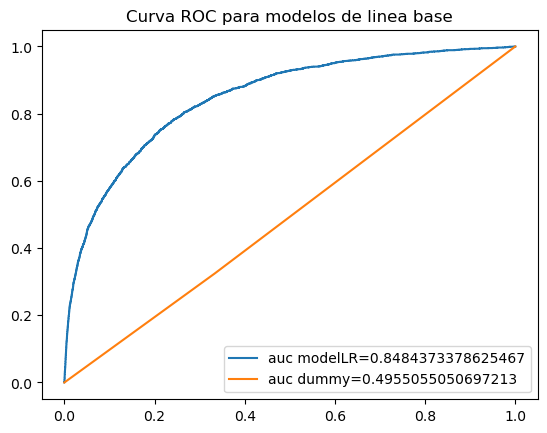

In [31]:
#show roc curve for model dummy and logistic regression in same plot
y_pred_proba = modelLR.predict_proba(X_test)[::,1]

fpr, tpr, th = roc_curve(y_test,  y_pred_proba, pos_label=1)
auc_metric = auc(fpr, tpr)

plt.plot(fpr, tpr,label="auc modelLR="+str(auc_metric))

y_pred_proba = modelDummy.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(y_test,  y_pred_proba, pos_label=1)
auc_metric = auc(fpr, tpr)

plt.plot(fpr, tpr,label="auc dummy="+str(auc_metric))

plt.legend(loc=4)
plt.title('Curva ROC para modelos de linea base')
plt.show()


# Selección de Modelo
Se realiza la implementación de diferentes modelos con el fin de evaluar cuál tiene mejores resultados para la predicción. Para esto se tiene en cuenta la metrica curva roc-auc, f1-score, precission y accuracy. 


In [16]:
# Entrenamiento de multiples modelos

# Maquinas de soporte vectorial
modelSVC       = svm.SVC(kernel='linear', probability = True).fit(X_train, y_train)
# Clasificador de K Neighbors
modelknn       = neighbors.KNeighborsClassifier(n_neighbors = 31).fit(X_train, y_train)
# Complemento del Naive Bayes
modelComplNB   = ComplementNB().fit(X_train, y_train)
# Arboles de decision
modelTreeClas  = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
# Gradient Boosting
modelGD = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05,
                                     max_depth=5, random_state=231) \
                                     .fit(X_train, y_train)
# Random forest
modelRanForest = RandomForestClassifier(n_estimators=100, max_depth=5, max_features = 'auto', criterion = 'gini', random_state=0).fit(X_train, y_train)
# Redes neuronales - Prospectos
ModelNN        = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=0).fit(X_train, y_train)
# ModelXGB
modelXGB = XGBClassifier( n_estimators = 150, learning_rate=0.05, max_depth = 5) \
                .fit(X_train, y_train)

c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


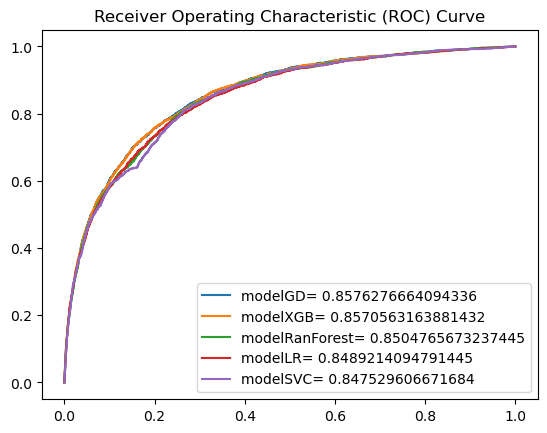

In [42]:
models = [
    ('modelGD', modelGD),
    ('modelXGB', modelXGB),
    ('modelRanForest', modelRanForest),
    ('modelLR', modelLR),
    ('modelSVC', modelSVC)
]

for name, model in models:
    # aqui se hace la curva roc con X_train
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, th = roc_curve(y_test,  y_pred_proba, pos_label=1)
    auc_metric = auc(fpr, tpr)

    plt.plot(fpr, tpr,label=name+'= '+str(auc_metric))
    plt.legend(loc=4)

plt.title('Receiver Operating Characteristic (ROC) Curve')  # Título del gráfico
plt.legend()  # Mostrar la leyenda de los modelos
plt.show()  # Mostrar el gráfico

En este primer análisis de los modelos de clasificación se encuentra que XGBoost y Gradient Boosting son los que obtienen mejores resultados en la curva ROC-AUC. Para validar que en este primer entrenamiento no se este generando algun sobreajuste en los resultados, se realiza una validación cruzada con 10 folds y 3 repeticiones. Esto quiere decir que en total se corren 30 iteración para cada uno de los clasificadores.

## Validación cruzada

In [54]:


# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

models = [
    ('modelRanForest', modelRanForest),
    ('modelSVC', modelSVC),
    ('modelGD', modelGD),
    ('modelXGB', modelXGB),
    ('modelLR',modelLR)
]

cv_df = pd.DataFrame()

for name, model in models:
    # evaluate the model and collect the scores
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    model_scores = pd.DataFrame(scores)
    model_scores['model_name'] = name
    cv_df = pd.concat([cv_df, model_scores], ignore_index=True)

column_order = ['model_name', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
cv_df = cv_df.reindex(columns=column_order)

# calculate mean by name in cv_df
cv_df.groupby(['model_name']).mean().sort_values('test_f1', ascending=False)


,test_accuracy,test_precision,test_recall,test_f1
model_name,,,,
modelGD,0.837550,0.805967,0.675360,0.734774
modelXGB,0.836388,0.807264,0.668999,0.731524
modelRanForest,0.805927,0.760937,0.609455,0.676656
modelLR,0.788307,0.748143,0.550593,0.634119
modelSVC,0.784342,0.805021,0.466002,0.590079


Los modelos XGBoost y GradientBoosting nuevamente destacan por unos buenos resultados en la métrica f1. Esta métrica corresponde a la media armonica entre la precisión y el recall.

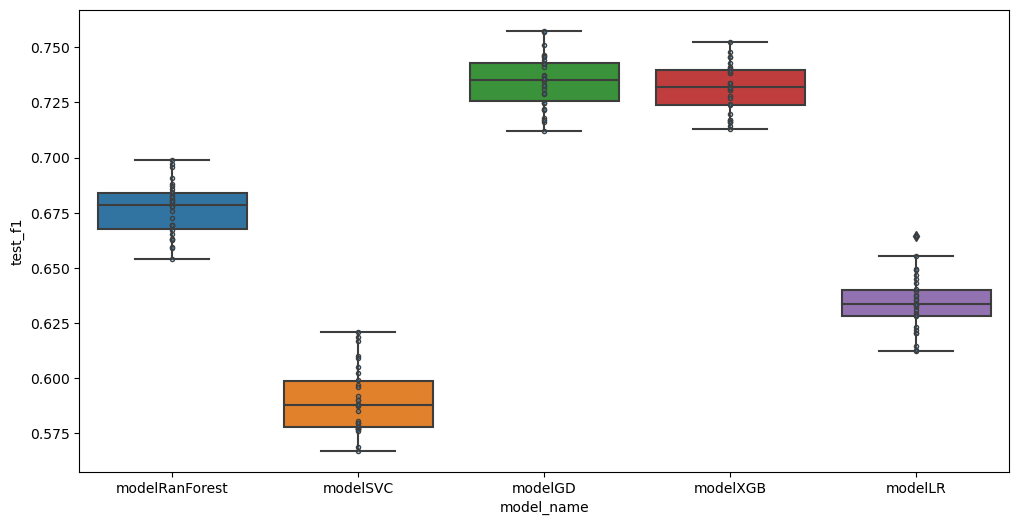

In [55]:
# Gráfica de f1-score de los modelos

fig = plt.figure(figsize=(12,6))

sns.boxplot(x='model_name', y='test_f1', data=cv_df)
sns.stripplot(x='model_name', y='test_f1', data=cv_df,
              size=1, jitter=False, edgecolor="gray", linewidth=3)
plt.show()

Se decide trabajar inicialmente con los modelos GradientBoosting y XGBoost. Se encuentran buenos resultados para estos modelos después de ejecutar la validación cruzada y el entrenamiento. Tuvimos en cuenta la métrica f1-score que da una estimación entre la precisión y la sensibilidad. También tuvimos muy presente la métrica de sensibilidad, teniendo en cuenta que los falsos negativos pueden ser muy riesgosos en el contexto del problemo. Esto debido a que predecir que una persona no va a presentar cuando realmente si puede tener riesgos de incumplimiento, podría afectar la cartera y generar perdidas en la entidad financiera.

# Implementación del modelo


## Gradient Boosting

In [23]:
# grid search for gradient boosting model
from sklearn.model_selection import GridSearchCV

# define the model with default hyperparameters
model = GradientBoostingClassifier(random_state=231)

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [100, 150, 200]
grid['learning_rate'] = [0.01, 0.05, 0.1]
grid['max_depth'] = [3, 5, 7]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, refit="f1",
                           scoring=['f1', 'recall', 'accuracy', 'roc_auc'], error_score=0)

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.747348 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [46]:
# print the results
results = pd.DataFrame(grid_result.cv_results_)
results.sort_values(by='rank_test_f1', inplace=True)
results[['mean_test_f1', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc',
         'param_n_estimators', 'param_learning_rate', 'param_max_depth']].head(5)

,mean_test_f1,mean_test_recall,mean_test_accuracy,mean_test_roc_auc,param_n_estimators,param_learning_rate,param_max_depth
23,0.747348,0.691353,0.844222,0.899655,200,0.1,5
26,0.745391,0.694263,0.841910,0.898710,200,0.1,7
22,0.745186,0.688836,0.843012,0.898759,150,0.1,5
25,0.744998,0.692430,0.842006,0.898727,150,0.1,7
24,0.742871,0.688154,0.841227,0.898192,100,0.1,7
17,0.742364,0.687723,0.840892,0.898889,200,0.05,7
16,0.739597,0.683411,0.839598,0.897752,150,0.05,7
14,0.739564,0.681039,0.840137,0.896697,200,0.05,5
21,0.739376,0.681003,0.839993,0.896747,100,0.1,5
20,0.736891,0.672486,0.839957,0.895767,200,0.1,3


Se observa una métrica AUC de 0.899 para la configuración con mejor score F1.

### Validación

In [30]:
# validate the model on test dataset
y_pred = grid_result.best_estimator_.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))



Accuracy: 89.88%
Precision: 30.61%
Recall: 54.08%
F1: 39.09%


Se obtiene un recall (sensibilidad) del 54.08%. Esto significa que el 54.08% de las predicciones son relevantes; personas que realmente van a presentar incumplimiento. Esta es una métrica muy importante para validar la capacidad predictiva del modelo.

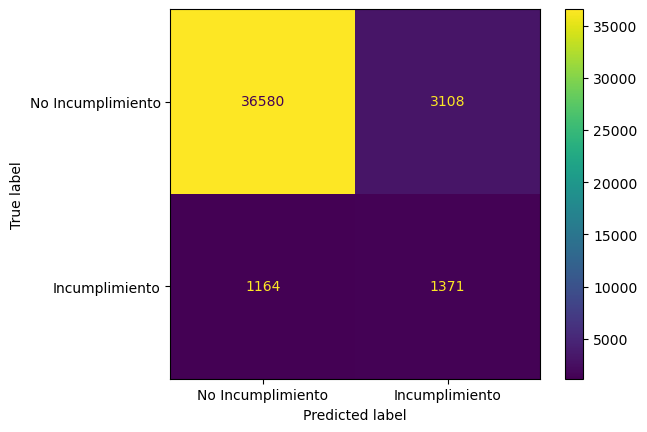

In [35]:
# display using ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Incumplimiento', 'Incumplimiento'])
disp.plot()
plt.show()

AUC: 0.855


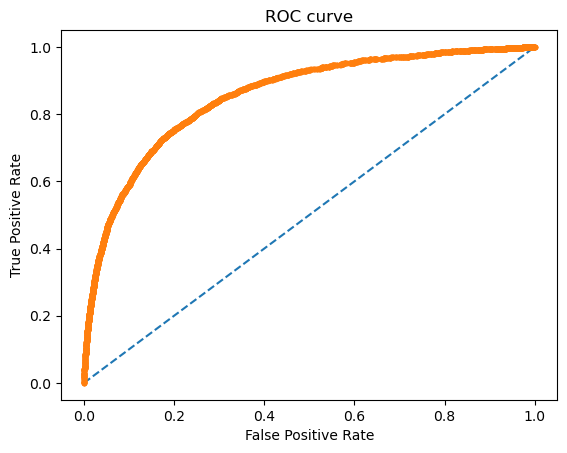

In [31]:
# roc curve for gradient boosting model
# predict probabilities
probs = grid_result.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [29]:
import joblib

# save the model to disk
filename = 'model/gradient_boosting_model.sav'
joblib.dump(grid_result.best_estimator_, filename)

['model/gradient_boosting_model.sav']

## XGBoost
Este modelo fue el segundo con mejores resultados en la etapa de selección del modelo. Vamos a ejecutar nuevamente un gridsearch para encontrar los mejores hipérparametros y luego entrenar el modelo con estos.

In [32]:
# grid search for XGBoost model
from sklearn.model_selection import GridSearchCV

# define the model with default hyperparameters
model = XGBClassifier(random_state=231)

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [100, 150, 200]
grid['learning_rate'] = [0.01, 0.05, 0.1]
grid['max_depth'] = [3, 5, 7]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=1, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, refit="f1",
                           scoring=['f1', 'recall', 'accuracy', 'roc_auc'], error_score=0)

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


KeyboardInterrupt: 